# Import libraries

In [2]:
import os
import re
import sys
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# 1. Feature generation

In [3]:
# after your check I add this to the config file
SHOP_DUPLICATE_SET = {
    0: 57,
    1: 58,
    10: 11
}

CORRECT_CITY_NAME = {
    '!Якутск': 'Якутск',
    'РостовНаДону': 'Ростов На Дону',
    'Цифровой': 'Интернет-магазин',
    'Выездная': 'Выездная торговля',
}

FEATURE_SET = {
    'date_block_item_cnt_mean': ['date_block_num'],
    'date_block_num_item_id_item_cnt_mean': ['date_block_num', 'item_id'],
    'date_block_num_shop_id_item_cnt_mean': ['date_block_num', 'shop_id'],
    'date_block_num_item_category_id_item_cnt_mean': ['date_block_num', 'item_category_id'],
    'date_shop_category_item_cnt_mean': ['date_block_num', 'shop_id', 'item_category_id'],
    'date_shop_category_sub_type_item_cnt_mean': ['date_block_num', 'shop_id', 'category_sub_type'],
    'date_block_num_city_item_id_item_cnt_mean': ['date_block_num', 'city', 'item_id']
}

In [4]:
def load_data(path_to_data):
    """Load all data from files and return a dictionary of DataFrames."""
    sales_train_data = pd.read_csv(os.path.join(path_to_data, "sales_train.csv"))
    test_data = pd.read_csv(os.path.join(path_to_data, "test.csv")).set_index('ID')
    items_data = pd.read_csv(os.path.join(path_to_data, "items.csv"))
    item_categories_data = pd.read_csv(os.path.join(path_to_data, "item_categories.csv"))
    shops_data = pd.read_csv(os.path.join(path_to_data, "shops.csv"))
    sub_data = pd.read_csv(os.path.join(path_to_data, "sample_submission.csv"))

    data = {
        'sales_train_data': sales_train_data,
        'test_data': test_data,
        'items_data': items_data,
        'item_categories_data': item_categories_data,
        'shops_data': shops_data,
        'sub_data': sub_data
    }

    return data


def remove_outliers(data):
    """Remove outliers from sales_train_data."""
    data = data[
        (data['item_cnt_day'] < 1000) &
        (data['item_price'] < 300000) &
        (data['item_price'] > 0)
    ]
    return data


def replace_duplicate_shop_ids(data, shop_duplicate_set):
    """Replace duplicate shop IDs for sales_train_data, test_data, and shops_data."""
    for key in ['sales_train_data', 'test_data', 'shops_data']:
        for old_id, new_id in shop_duplicate_set.items():
            data[key].loc[data[key]['shop_id'] == old_id, 'shop_id'] = new_id
    return data


def extract_shop_subcategories(data):
    """Extract subcategories for shops_data."""
    data['city'] = data['shop_name'].apply(lambda x: x.split(' ')[0])
    data['shop_type'] = data['shop_name'].apply(lambda x: x.split(' ')[1])

    shop_type_count = data['shop_type'].value_counts()
    valid_shop_types = shop_type_count[shop_type_count >= 5].index.to_list()

    data['shop_type'] = data['shop_type'].apply(
        lambda x: x if x in valid_shop_types else 'other'
    )
    return data


def extract_category_subcategories(data):
    """Extract subcategories for item_categories_data."""
    data['item_category_type'] = data['item_category_name'].apply(lambda x: x.split(' ')[0])
    data['item_category_type'] = data['item_category_type'].replace(
        {'Игровые': 'Games', 'Аксессуары': 'Games'}
    )

    category_type_count = data['item_category_type'].value_counts()
    valid_category_types = category_type_count[category_type_count > 5].index.to_list()

    data['item_category_type'] = data['item_category_type'].apply(
        lambda x: x if x in valid_category_types else 'other'
    )
    data['category_sub_type'] = data['item_category_name'].apply(
        lambda x: x.split('-')[1].strip() if '-' in x else x.split(' ')[-1]
    )
    return data


def calculate_revenue(data):
    """Create revenue feature for sales_train_data."""
    data['revenue'] = data['item_price'] * data['item_cnt_day']
    return data


def correct_city_names(data, city_name_mapping):
    """Correct city names for shops_data."""
    data['city'] = data['city'].replace(city_name_mapping)
    return data


def transform_test_data(data):
    """Transform test data into the appropriate format."""
    data['date_block_num'] = 34
    data['shop_id'] = data['shop_id'].astype('int8')
    data['item_id'] = data['item_id'].astype('int16')
    data['date_block_num'] = data['date_block_num'].astype('int8')
    data.reset_index(drop=True, inplace=True)
    return data


def encode_data(data, columns):
    """Encode categorical features using OrdinalEncoder."""
    encoder = OrdinalEncoder()
    data[columns] = encoder.fit_transform(data[columns])
    return data


# Load data
path_to_data = r'..\data'
data = load_data(path_to_data)

# Remove outliers from sales_train_data
data['sales_train_data'] = remove_outliers(data['sales_train_data'])

# Handle duplicate shop IDs
data = replace_duplicate_shop_ids(data, SHOP_DUPLICATE_SET)

# Extract and correct subcategories for shops and item categories
data['shops_data'] = extract_shop_subcategories(data['shops_data'])
data['shops_data'] = correct_city_names(data['shops_data'], CORRECT_CITY_NAME)

data['item_categories_data'] = extract_category_subcategories(data['item_categories_data'])

# Encode categorical features for shops_data and item_categories_data
data['shops_data'] = encode_data(data['shops_data'], ['city', 'shop_type'])
data['shops_data'] = data['shops_data'][['shop_id', 'city', 'shop_type']].drop_duplicates(subset=['shop_id'])

data['item_categories_data'] = encode_data(data['item_categories_data'], ['category_sub_type', 'item_category_type'])
data['item_categories_data'] = data['item_categories_data'][['item_category_id', 'item_category_type', 'category_sub_type']]

# Prepare items_data in the required format
data['items_data'] = data['items_data'][['item_id', 'item_category_id']]

# Add revenue feature for sales_train_data
data['sales_train_data'] = calculate_revenue(data['sales_train_data'])

# Transform test data
data['test_data'] = transform_test_data(data['test_data'])

In [5]:
for df in data:
    print(data[df].shape)
print(SHOP_DUPLICATE_SET)

(2935845, 7)
(214200, 3)
(22170, 2)
(84, 3)
(57, 3)
(214200, 2)
{0: 57, 1: 58, 10: 11}


In [6]:
for df in data:
    print(df)

sales_train_data
test_data
items_data
item_categories_data
shops_data
sub_data


In [7]:
data['test_data']

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34
214198,45,19648,34


In [8]:
# Step 1: Matrix Construction Functions
def generate_sales_matrix(df, cols):
    """
    Generates a matrix of combinations for 'date_block_num', 'shop_id', and 'item_id'.
    """
    matrix = []
    for i in range(34):
        sales = df[df['date_block_num'] == i]
        matrix.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype=np.int16))
    return np.vstack(matrix)


def create_matrix_dataframe(matrix, cols):
    """
    Converts the generated matrix into a pandas DataFrame, and sorts the values.
    """
    matrix_df = pd.DataFrame(data=matrix, columns=cols)
    return matrix_df.sort_values(cols).reset_index(drop=True)


def add_item_cnt_month(matrix_df, df, cols):
    """
    Merges item_cnt_month data into the matrix DataFrame and appends test data.
    """
    matrix_df = pd.merge(matrix_df, df.groupby(cols)['item_cnt_day'].sum().reset_index(), on=cols, how='left').fillna(0)
    matrix_df['item_cnt_month'] = matrix_df['item_cnt_day'].astype('float16')
    matrix_df.drop(columns=['item_cnt_day'], inplace=True)
    return matrix_df


def append_test_data(matrix_df, test_data):
    """
    Appends test data to the matrix DataFrame.
    """
    matrix_df = pd.concat([matrix_df, test_data], ignore_index=True)
    matrix_df['item_cnt_month'] = matrix_df['item_cnt_month'].fillna(0)
    return matrix_df


def merge_with_external_data(matrix_df, items_data, item_categories_data, shops_data):
    """
    Merges item, category, and shop data into the matrix DataFrame.
    """
    matrix_df = pd.merge(matrix_df, items_data, on='item_id', how='left')
    matrix_df = pd.merge(matrix_df, item_categories_data, on='item_category_id', how='left')
    matrix_df = pd.merge(matrix_df, shops_data, on='shop_id', how='left')
    return matrix_df


# Step 2: Lag Feature Creation
def create_lag_feature(df, lags, features):
    for feature in features:
        for lag in lags:
            if f'{feature}_lag_{lag}' not in df.columns:
                df[f'{feature}_lag_{lag}'] = df.groupby(['shop_id', 'item_id'])[feature].shift(lag)
    return df


# Step 3: Creating Lags for Mean Sales Values
def merge_groupby_mean(df, group_cols, agg_col, new_col_name, dtype='float16'):
    if not isinstance(df, list):
        df = [df, df]

    df_process = 0
    df_with_info = 1
    
    temp = df[df_with_info].groupby(group_cols)[agg_col].mean().reset_index()
    temp.columns = group_cols + [new_col_name]
    df[df_process] = pd.merge(df[df_process], temp, on=group_cols, how='left')
    df[df_process][new_col_name] = df[df_process][new_col_name].astype(dtype)
    return df[df_process]


def create_lags_feature_by_item_cnt_mean(df, feature_set, lags):
    df['item_cnt_month'] = df['item_cnt_month'].astype('float32')
    for feature, columns in feature_set.items():
        df = merge_groupby_mean(df, columns, 'item_cnt_month', feature)
        df = create_lag_feature(df, lags, [feature])
        df.drop(columns=feature, inplace=True)
    df['item_cnt_month'] = df['item_cnt_month'].astype('float16')
    return df


# Step 4: Processing Price Features
def process_price_features(df, sales_train_data, lags):
    df = merge_groupby_mean([df, sales_train_data], ['item_id'], 'item_price', 'item_id_price_mean')
    df = merge_groupby_mean([df, sales_train_data], ['date_block_num', 'item_id'], 'item_price', 'date_item_id_price_mean')

    df = create_lag_feature(df, lags, ['date_item_id_price_mean'])

    for i in lags:
        df[f'delta_price_lag_{i}'] = (df[f'date_item_id_price_mean_lag_{i}'] - df['item_id_price_mean']) / df['item_id_price_mean']
        df[f'delta_price_lag_{i}'] = df[f'delta_price_lag_{i}'].astype('float16')

    df['nearest_delta_price_lag'] = df.apply(select_changes, axis=1, lags=lags)
    df['nearest_delta_price_lag'] = df['nearest_delta_price_lag'].astype('float16')

    drop_columns = ['item_id_price_mean', 'date_item_id_price_mean'] + [f'delta_price_lag_{i}' for i in lags]
    df.drop(columns=drop_columns, inplace=True)

    return df


def select_changes(row, lags):
    for i in lags:
        if row[f'delta_price_lag_{i}'] != 0:
            return row[f'delta_price_lag_{i}']
    return 0


# Step 5: Processing Revenue Features
def process_revenue_features(df, sales_train_data, lags):
    df = merge_groupby_mean([df, sales_train_data], ['shop_id'], 'revenue', 'shop_id_revenue_mean')
    df = merge_groupby_mean([df, sales_train_data], ['date_block_num', 'shop_id'], 'revenue', 'date_shop_id_revenue_mean')

    df['delta_revenue'] = (df['date_shop_id_revenue_mean'] - df['shop_id_revenue_mean']) / df['shop_id_revenue_mean']
    df['delta_revenue'] = df['delta_revenue'].astype('float16')

    df = create_lag_feature(df, lags, ['delta_revenue'])

    df.drop(columns=['delta_revenue', 'shop_id_revenue_mean', 'date_shop_id_revenue_mean'], inplace=True)

    return df


# Step 6: Adding Date Features and Filling NaN
def add_date_features(df):
    df['month'] = df['date_block_num'] % 12
    df['sezon'] = df['month'] // 4
    return df


def fill_na(df):
    for col in df.columns:
        if 'lag' in col and df[col].isnull().any():
            df[col] = df[col].fillna(0)
    return df


# Main pipeline
def main_pipeline(sales_train_data, test_data, items_data, item_categories_data, shops_data):
    cols = ['date_block_num', 'shop_id', 'item_id']
    
    # Step 1: Matrix Creation
    matrix = generate_sales_matrix(sales_train_data, cols)
    matrix_df = create_matrix_dataframe(matrix, cols)
    matrix_df = add_item_cnt_month(matrix_df, sales_train_data, cols)
    matrix_df = append_test_data(matrix_df, test_data)
    matrix_df = merge_with_external_data(matrix_df, items_data, item_categories_data, shops_data)
    
    # Step 2: Create lags for item_cnt_month
    lags = [1, 2, 3, 6, 12]
    train_test_df = create_lag_feature(matrix_df, lags, ['item_cnt_month'])

    # Step 3: Create lags for mean sales values
    train_test_df = create_lags_feature_by_item_cnt_mean(train_test_df, FEATURE_SET, lags)

    # Step 4: Process price features and create price lags
    train_test_df = process_price_features(train_test_df, sales_train_data, lags)

    # Step 5: Process revenue features and create revenue lags
    train_test_df = process_revenue_features(train_test_df, sales_train_data, lags)

    # Step 6: Add date features and fill missing values
    train_test_df = add_date_features(train_test_df)
    train_test_df = fill_na(train_test_df)

    return train_test_df


# Call the pipeline with the required datasets
final_df = main_pipeline(data['sales_train_data'], data['test_data'], data['items_data'], data['item_categories_data'], data['shops_data'])

In [9]:
final_df

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
0,0,2,19,0.0,40,1.0,7.0,0.0,4.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,0,2,27,1.0,19,2.0,13.0,0.0,4.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2,0,2,28,0.0,30,2.0,56.0,0.0,4.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,0,2,29,0.0,23,2.0,19.0,0.0,4.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,0,2,32,0.0,40,1.0,7.0,0.0,4.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,55,4.0,5.0,20.0,4.0,1.0,...,199.000,0.0,-0.475098,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2
11128000,34,45,16188,0.0,64,5.0,43.0,20.0,4.0,0.0,...,0.000,0.0,0.081116,0.200928,0.326416,0.000000,0.000000,0.000000,10,2
11128001,34,45,15757,0.0,55,4.0,5.0,20.0,4.0,0.0,...,208.125,199.0,0.155884,0.200928,0.326416,-0.121521,0.258789,0.468506,10,2
11128002,34,45,19648,0.0,40,1.0,7.0,20.0,4.0,0.0,...,99.000,0.0,-0.091736,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2


In [10]:
final_df = final_df[final_df.date_block_num > 11]
final_df[final_df.date_block_num == 34]

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
10913804,34,5,5037,0.0,19,2.0,13.0,3.0,3.0,0.0,...,1543.000,2570.0,-0.222046,0.140625,0.232666,-0.030518,0.172607,0.496826,10,2
10913805,34,5,5320,0.0,55,4.0,5.0,3.0,3.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10,2
10913806,34,5,5233,0.0,19,2.0,13.0,3.0,3.0,1.0,...,790.000,0.0,0.496826,0.140625,0.232666,-0.030518,0.172607,0.000000,10,2
10913807,34,5,5232,0.0,23,2.0,19.0,3.0,3.0,0.0,...,0.000,0.0,0.505371,0.140625,0.232666,-0.030518,0.000000,0.000000,10,2
10913808,34,5,5268,0.0,20,2.0,14.0,3.0,3.0,0.0,...,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,55,4.0,5.0,20.0,4.0,1.0,...,199.000,0.0,-0.475098,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2
11128000,34,45,16188,0.0,64,5.0,43.0,20.0,4.0,0.0,...,0.000,0.0,0.081116,0.200928,0.326416,0.000000,0.000000,0.000000,10,2
11128001,34,45,15757,0.0,55,4.0,5.0,20.0,4.0,0.0,...,208.125,199.0,0.155884,0.200928,0.326416,-0.121521,0.258789,0.468506,10,2
11128002,34,45,19648,0.0,40,1.0,7.0,20.0,4.0,0.0,...,99.000,0.0,-0.091736,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2


In [11]:
final_df

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
4488710,12,2,27,0.0,19,2.0,13.0,0.0,4.0,0.0,...,1398.000,2324.0,-0.282715,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488711,12,2,30,0.0,40,1.0,7.0,0.0,4.0,0.0,...,385.500,0.0,-0.483398,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488712,12,2,31,0.0,37,1.0,4.0,0.0,4.0,0.0,...,699.000,0.0,-0.137451,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488713,12,2,32,1.0,40,1.0,7.0,0.0,4.0,0.0,...,346.000,338.0,-0.407227,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488714,12,2,33,1.0,37,1.0,4.0,0.0,4.0,1.0,...,195.500,488.5,-0.225464,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,55,4.0,5.0,20.0,4.0,1.0,...,199.000,0.0,-0.475098,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2
11128000,34,45,16188,0.0,64,5.0,43.0,20.0,4.0,0.0,...,0.000,0.0,0.081116,0.200928,0.326416,0.000000,0.000000,0.000000,10,2
11128001,34,45,15757,0.0,55,4.0,5.0,20.0,4.0,0.0,...,208.125,199.0,0.155884,0.200928,0.326416,-0.121521,0.258789,0.468506,10,2
11128002,34,45,19648,0.0,40,1.0,7.0,20.0,4.0,0.0,...,99.000,0.0,-0.091736,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2


# 2 Validation

In [15]:
class validator:
    
    def __init__(self, model):
        self.model = model
    
    def validation(self, data, start_size_window, end_size_of_window, number_of_fold):

        def get_target(data):
             return data['item_cnt_month']

        def get_features(data):
            return data.drop(['item_cnt_month'], axis=1)

        report = []
        
        for i in range(number_of_fold):
      
            size_window = start_size_window + 1 + i * abs(start_size_window - end_size_of_window) / number_of_fold
            print(size_window)
            train_data = data[data.date_block_num < size_window]
            test_data = data[data.date_block_num == size_window]
                           
            X_train = get_features(train_data)
            Y_train = get_target(train_data)

            X_test = get_features(test_data)
            Y_test = get_target(test_data)


            print(i, 'load data')
            self.model.fit(
                        X_train, 
                        Y_train, 
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        verbose=True
            )
            print(i,'fit')
            Y_pred_train = self.model.predict(X_train)
            Y_pred_test = self.model.predict(X_test)
            print(i,'predict')
            train_rmse = mean_squared_error(Y_train, Y_pred_train, squared=False)
            test_rmse = mean_squared_error(Y_test, Y_pred_test, squared=False)
           
            report.append({
                'iteration': i,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse
                })


        report_df = pd.DataFrame(report)
        
        return report_df
            

In [16]:
from xgboost import XGBRegressor 
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=20)

xgb_model.set_params(eval_metric="rmse")
xgb_model.set_params(early_stopping_rounds = 50)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.3, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=300, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
Validator = validator(xgb_model)
report = Validator.validation(final_df, 23, 33, 10)

In [ ]:
report

## Hyperparameter optimization

In [18]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [6, 7, 8, 9, 10],
    'min_child_weight': [1, 5, 10, 300],
    'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3],
    'eval_metric' : ['rmse'],
    'early_stopping_rounds' : [10],
    'early_stopping_rounds' : [10],
    
}

from xgboost import XGBRegressor 
xgb_model = XGBRegressor()

random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=50,              
    scoring='neg_root_mean_squared_error',
    cv=3,                   
    verbose=1,              
    n_jobs=4,
    random_state=20
)

In [13]:
X_train = final_df[final_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = final_df[final_df.date_block_num < 33]['item_cnt_month']
X_valid = final_df[final_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = final_df[final_df.date_block_num == 33]['item_cnt_month']

In [19]:
random_search.fit(X_train, Y_train,
    eval_set=[(X_valid, Y_valid)],
    verbose=True)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	validation_0-rmse:2.62672
[1]	validation_0-rmse:2.52853
[2]	validation_0-rmse:2.47445
[3]	validation_0-rmse:2.40025
[4]	validation_0-rmse:2.33988
[5]	validation_0-rmse:2.28553
[6]	validation_0-rmse:2.25491
[7]	validation_0-rmse:2.21555
[8]	validation_0-rmse:2.18759
[9]	validation_0-rmse:2.15897
[10]	validation_0-rmse:2.15628
[11]	validation_0-rmse:2.13929
[12]	validation_0-rmse:2.13667
[13]	validation_0-rmse:2.12431
[14]	validation_0-rmse:2.11195
[15]	validation_0-rmse:2.09996
[16]	validation_0-rmse:2.08804
[17]	validation_0-rmse:2.08573
[18]	validation_0-rmse:2.07866
[19]	validation_0-rmse:2.06818
[20]	validation_0-rmse:2.07421
[21]	validation_0-rmse:2.05492
[22]	validation_0-rmse:2.04887
[23]	validation_0-rmse:2.05162
[24]	validation_0-rmse:2.05244
[25]	validation_0-rmse:2.05461
[26]	validation_0-rmse:2.04995
[27]	validation_0-rmse:2.05209
[28]	validation_0-rmse:2.04911
[29]	validation_0-rmse:2.04775
[30]	validation_0-r

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.3, 0.6, 0.8,
                                                             1.0],
                                        'early_stopping_rounds': [10],
                                        'eval_metric': ['rmse'],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 5, 10, 300],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=20, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [21]:
print('Best Parameters:')
print(random_search.best_params_)

Best Parameters:
{'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 300, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2, 'eval_metric': 'rmse', 'early_stopping_rounds': 10, 'colsample_bytree': 0.3}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [22]:
import os
import json

artifacts_dir = "../artifacts"

best_model = random_search.best_estimator_
model_path = os.path.join(artifacts_dir, "best_model.json")
best_model.save_model(model_path)

In [54]:
with open(os.path.join(artifacts_dir, "best_model_params.json"), "w") as f:
    json.dump(random_search.best_params_, f)

In [23]:
best_xgb_model = random_search.best_estimator_

In [24]:
Validator = validator(best_xgb_model)
report = Validator.validation(final_df, 23, 33, 10)

NameError: name 'validator' is not defined

In [ ]:
report

# Feature importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import time

start_time = time.time()

model = RandomForestRegressor(
    n_estimators=100,    # Number of trees
    max_depth=8,         # Maximum depth of each tree
    min_samples_split=2, # Minimum number of samples required to split
    min_samples_leaf=1,  # Minimum number of samples required in a leaf node
    random_state=42,     # Seed for reproducibility
    n_jobs=-1            # Use all CPU cores available
)


model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)


rmse = mean_squared_error(Y_valid, Y_pred, squared=False)
print("RMSE:", rmse)

print("Training time:", time.time() - start_time)

In [ ]:
feature_importance = model.feature_importances_
feature_importances_df = (pd.DataFrame({'feature' : X_train.columns,
                                   'importance' : feature_importance}))
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df

In [ ]:
plt.figure(figsize=(10, 14))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

from xgboost import plot_importance
plot_features(best_xgb_model, (10,14))


**The random forest model relies more on lagged features while xgbost understands categorical features better.**

# Explainability layer

In [25]:
X_sampled = X_train.sample(10000, random_state=10)
X_sampled

,date_block_num,shop_id,item_id,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
8864556,25,30,8436,49,3.0,40.0,13.0,4.0,0.0,0.0,...,249.0000,244.5,0.009117,0.279297,0.669922,0.619141,0.003265,0.025589,1,0
6961950,19,28,13941,37,1.0,4.0,13.0,4.0,1.0,0.0,...,126.9375,98.0,0.165161,-0.113098,-0.024048,-0.056091,-0.050751,-0.241821,7,1
5465601,14,54,4836,20,2.0,14.0,26.0,4.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0
7880791,22,22,14350,40,1.0,7.0,13.0,0.0,0.0,0.0,...,185.5000,399.0,-0.711426,0.155640,0.262451,-0.170654,0.048859,0.563965,10,2
9470347,27,44,4694,57,4.0,11.0,20.0,4.0,0.0,0.0,...,299.0000,299.0,0.107422,0.060669,0.147949,0.080872,0.227051,-0.102234,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227855,14,13,19812,38,1.0,4.0,8.0,4.0,0.0,0.0,...,1333.0000,0.0,0.026016,0.270752,0.563965,0.076416,-0.270752,0.000000,2,0
10440228,31,56,15835,40,1.0,7.0,27.0,3.0,2.0,1.0,...,188.1250,197.0,0.056000,-0.048065,0.086060,0.329346,0.130005,-0.154297,7,1
4850891,13,4,2072,19,2.0,13.0,2.0,4.0,0.0,0.0,...,2672.0000,0.0,-0.127441,0.077332,0.219849,0.361328,-0.315186,0.000000,1,0
8520314,24,22,31,37,1.0,4.0,13.0,0.0,1.0,0.0,...,411.2500,499.0,-0.216064,0.279785,0.561035,0.155640,-0.227051,-0.281982,0,0


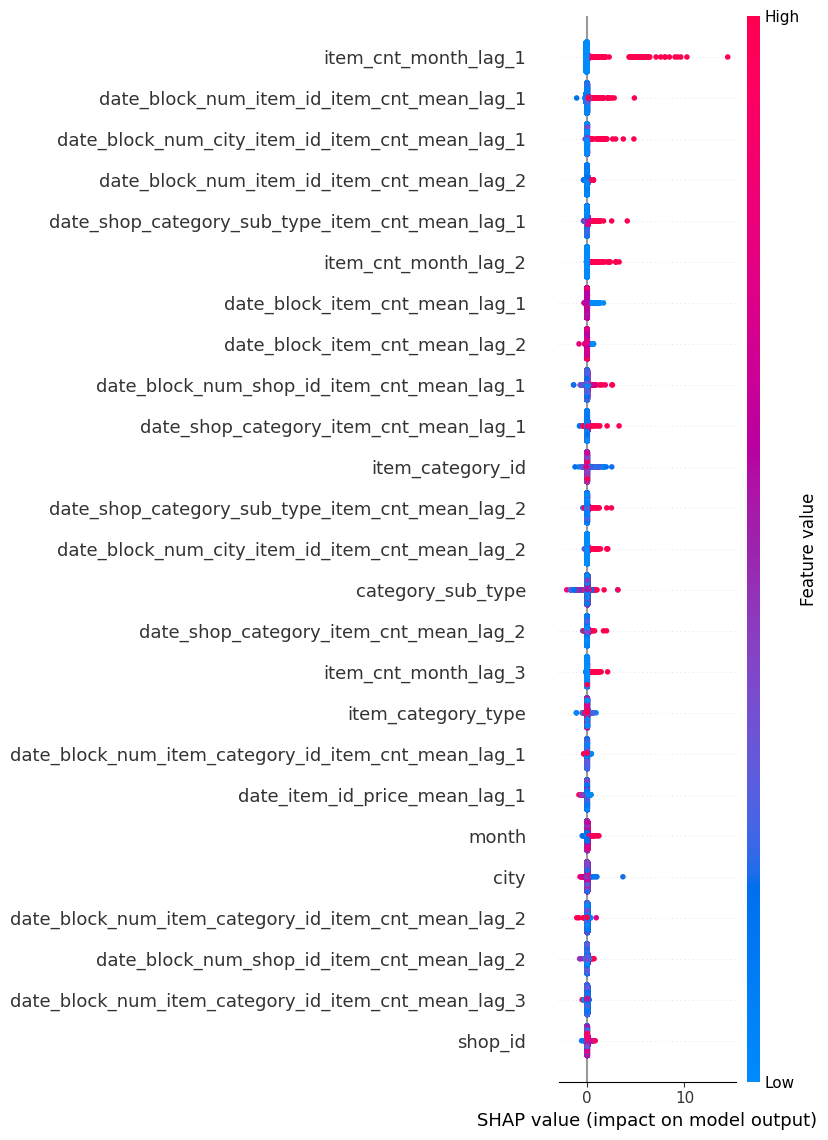

In [33]:
import shap
shap_test = shap.TreeExplainer(best_xgb_model).shap_values(X_sampled)
shap.summary_plot(shap_test, X_sampled,
                      max_display=25, show=False)
plt.savefig("../artifacts/shap_summary_plot.png", bbox_inches='tight')

**high values ​​of lagged variables contribute to a higher number in the prediction; the influence of categorical features is difficult to interpret**

# Error analys

## Initail neptune

In [114]:
from io import BytesIO
import json
import neptune

credentials_path = "../credentials/neptune_credentials.json"

with open(credentials_path, "r") as file:
    credentials = json.load(file)
    
neptune_api_token = credentials["NEPTUNE_API_TOKEN"]


In [115]:
run = neptune.init_run(
    project="andrei-shemerei/DS-project",
    api_token=neptune_api_token,
    capture_hardware_metrics=False,
    capture_stdout=False,
    capture_stderr=False,
    capture_traceback=False,
    source_files=["../**/*.dvc"]
    )

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andrei-shemerei/DS-project/e/DSPROJ-20


In [121]:
run["plots/shap_summary_plot"].upload("../artifacts/shap_summary_plot.png")

best_xgb_model.save_model("../artifacts/xgboost_model.json")
run["artifacts/xgboost_model"].upload("../artifacts/xgboost_model.json")
run["artifacts/xgboost_model_params"].upload("../artifacts/best_model_params.json")
run["artifacts/notebook"].upload("Baseline modeling.ipynb")

run["metadata/package_version"] = "0.0.1"
run["metadata/requierements"].upload("../requirements.txt")



In [103]:
import tempfile

def save_plot_to_neptune(run, plt_obj, key):
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
        plt_obj.savefig(temp_file.name, format="png")
        temp_file.flush()
        run[key].upload(temp_file.name)
    plt_obj.close()

## Error calculation

In [122]:
df = final_df[final_df.date_block_num < 34]

In [123]:
X = df.drop(['item_cnt_month'], axis=1)
Y_real = df['item_cnt_month']

In [124]:
X

,date_block_num,shop_id,item_id,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
4488710,12,2,27,19,2.0,13.0,0.0,4.0,0.0,0.0,...,1398.00,2324.0,-0.282715,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488711,12,2,30,40,1.0,7.0,0.0,4.0,0.0,0.0,...,385.50,0.0,-0.483398,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488712,12,2,31,37,1.0,4.0,0.0,4.0,0.0,0.0,...,699.00,0.0,-0.137451,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488713,12,2,32,40,1.0,7.0,0.0,4.0,0.0,0.0,...,346.00,338.0,-0.407227,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488714,12,2,33,37,1.0,4.0,0.0,4.0,1.0,2.0,...,195.50,488.5,-0.225464,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913799,33,59,22162,40,1.0,7.0,29.0,4.0,0.0,1.0,...,379.25,0.0,-0.085815,0.312744,-0.043762,-0.130859,0.228149,0.000000,9,2
10913800,33,59,22163,40,1.0,7.0,29.0,4.0,0.0,0.0,...,0.00,0.0,0.026581,0.312744,-0.043762,0.000000,0.000000,0.000000,9,2
10913801,33,59,22164,37,1.0,4.0,29.0,4.0,0.0,0.0,...,719.00,0.0,-0.230591,0.312744,-0.043762,-0.130859,0.228149,0.000000,9,2
10913802,33,59,22166,54,3.0,62.0,29.0,4.0,0.0,0.0,...,150.00,150.0,0.000000,0.312744,-0.043762,-0.130859,0.228149,0.241211,9,2


In [125]:
Y_predict = best_xgb_model.predict(X)

In [126]:
error = Y_real - Y_predict
abs_error = np.abs(error)

In [127]:
rmse = np.sqrt(mean_squared_error(Y_real, Y_predict))
print(rmse)

2.6166787


In [128]:
run["rmse_on_all_data"] = rmse

## How my model predict small - large target

In [83]:
Y_real = Y_real.astype('float32')
abs_error = abs_error.astype('float32')

max_val = Y_real.max() + 1
bins = [0, 10, 50, 100, max_val]
bin_labels = ['small', 'medium', 'large', 'very large']

y_val_binned = pd.cut(Y_real, bins=bins, labels=bin_labels, include_lowest=True)

error_df = pd.DataFrame({'error': abs_error, 'bin': y_val_binned})


error_by_bin = error_df.groupby('bin')['error'].mean()
print("Mean absolute error by target size:")
print(error_by_bin)

Mean absolute error by target size:
bin
small           0.305243
medium         11.825901
large          43.596146
very large    147.774612
Name: error, dtype: float32


C:\Users\Asus\AppData\Local\Temp\ipykernel_3580\3500316219.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = error_df.groupby('bin')['error'].mean()


In [131]:
plt.bar(error_by_bin.index, error_by_bin.values)
plt.xlabel("Target Size (Binned)")
plt.ylabel("Mean Absolute Error")
plt.title("Error by Target Size")
save_plot_to_neptune(run, plt, "plots/error_by_target_size")

## How my model predict target with small - large dinamic

In [86]:
col= []
for i in range(1, 4):
    col.append(f'item_cnt_month_lag_{i}')
df = X[col]
df = df.assign(item_cnt_month_lag_0=Y_real)
df = df.assign(abs_error=abs_error)
df

,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_0,abs_error
4488710,0.0,0.0,0.0,0.0,0.058581
4488711,0.0,0.0,0.0,0.0,0.120671
4488712,0.0,0.0,0.0,0.0,0.112949
4488713,0.0,0.0,0.0,1.0,0.829310
4488714,1.0,2.0,0.0,1.0,0.642990
...,...,...,...,...,...
10913799,0.0,1.0,0.0,0.0,0.147717
10913800,0.0,0.0,0.0,0.0,0.159894
10913801,0.0,0.0,1.0,0.0,0.186094
10913802,0.0,0.0,0.0,0.0,0.019818


In [87]:
cols = ['item_cnt_month_lag_0', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'abs_error']
df = df[cols]

df = df[~((df['item_cnt_month_lag_0'] == 0) & (df['item_cnt_month_lag_1'] == 0) & (df['item_cnt_month_lag_2'] == 0) & (df['item_cnt_month_lag_3'] == 0))]

df['pct_change_lag0_lag1'] = (df['item_cnt_month_lag_1'] - df['item_cnt_month_lag_0']).div(df['item_cnt_month_lag_0'].replace(0, 1)) * 100
df['pct_change_lag1_lag2'] = (df['item_cnt_month_lag_2'] - df['item_cnt_month_lag_1']).div(df['item_cnt_month_lag_1'].replace(0, 1)) * 100
df['pct_change_lag2_lag3'] = (df['item_cnt_month_lag_3'] - df['item_cnt_month_lag_2']).div(df['item_cnt_month_lag_2'].replace(0, 1)) * 100




error_analysis_results = {}


for threshold in range(0, 160, 5):

    df['small_dynamic'] = (
    (df[['pct_change_lag0_lag1', 'pct_change_lag1_lag2', 'pct_change_lag2_lag3']].abs().mean(axis=1) >= threshold) &
    (df[['pct_change_lag0_lag1', 'pct_change_lag1_lag2', 'pct_change_lag2_lag3']].abs().mean(axis=1) <= threshold + 5))

    small_dynamic_error = df[df['small_dynamic'] == True]['abs_error'].mean()

    error_analysis_results[threshold] = {
        'small_dynamic_error': small_dynamic_error
    }

for threshold, errors in error_analysis_results.items():
    print(f"Dinamic: {threshold} - {threshold+5} %")
    print(f"MAE: {errors['small_dynamic_error']}")
    print("-" * 50)


Dinamic: 0 - 5 %
MAE: 0.5619696974754333
--------------------------------------------------
Dinamic: 5 - 10 %
MAE: 12.169185638427734
--------------------------------------------------
Dinamic: 10 - 15 %
MAE: 5.543304443359375
--------------------------------------------------
Dinamic: 15 - 20 %
MAE: 2.110750913619995
--------------------------------------------------
Dinamic: 20 - 25 %
MAE: 4.671083927154541
--------------------------------------------------
Dinamic: 25 - 30 %
MAE: 3.162872314453125
--------------------------------------------------
Dinamic: 30 - 35 %
MAE: 0.8442126512527466
--------------------------------------------------
Dinamic: 35 - 40 %
MAE: 3.405158042907715
--------------------------------------------------
Dinamic: 40 - 45 %
MAE: 2.9112138748168945
--------------------------------------------------
Dinamic: 45 - 50 %
MAE: 1.396165132522583
--------------------------------------------------
Dinamic: 50 - 55 %
MAE: 1.4069279432296753
--------------------------

In [88]:
error_analysis_results_df = pd.DataFrame(error_analysis_results)
error_analysis_results_df

,0,5,10,15,20,25,30,35,40,45,...,110,115,120,125,130,135,140,145,150,155
small_dynamic_error,0.56197,12.169186,5.543304,2.110751,4.671084,3.162872,0.844213,3.405158,2.911214,1.396165,...,1.346044,0.968215,1.139736,1.703876,0.81077,2.179337,1.455052,1.339687,1.32948,1.25382


In [130]:
dynamic_ranges = [f"{i}-{i+5}%" for i in range(0, 160, 5)]

plt.figure(figsize=(12, 6))
plt.plot(dynamic_ranges, error_analysis_results_df.loc['small_dynamic_error'], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel("Dynamic Change Range (%)")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error by Dynamic Change Range")
plt.grid(True)
plt.tight_layout()
save_plot_to_neptune(run, plt, "plots/error_by_dynamic_change_range")

**The graph shows that examples with low dynamics are worse predicte**

## Find the samples with the highest errors

In [91]:
top_errors = abs_error.sort_values(ascending=False).head(160)
print("Top 10 samples with highest absolute errors:")
top_errors.head(10)

Top 10 samples with highest absolute errors:


10494631    1588.886597
10652267    1561.820801
9530323     1236.755493
8706158     1077.066162
7755717     1070.102295
10652269    1035.821533
8256138      939.617188
5644753      897.773071
7193978      848.925171
9344140      804.481445
Name: item_cnt_month, dtype: float32

In [92]:
high_error_samples = X.loc[top_errors.index]
high_error_samples

,date_block_num,shop_id,item_id,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
10494631,32,12,9248,80,1.0,28.0,7.0,0.0,19.0,12.0,...,0.000000,0.000000,-0.046844,-0.541016,-0.426025,-0.392822,0.000000,0.000000,8,2
10652267,32,55,9249,8,1.0,0.0,7.0,0.0,19.0,12.0,...,0.000000,0.000000,-0.046173,-0.060059,-0.250000,-0.090759,0.000000,0.000000,8,2
9530323,27,55,3730,31,2.0,62.0,7.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
8706158,24,55,5917,31,2.0,62.0,7.0,0.0,50.0,3.0,...,199.000000,0.000000,-0.533203,0.429443,0.282715,0.497314,-0.504395,0.000000,0,0
7755717,21,55,19437,31,2.0,62.0,7.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6791089,18,54,20949,71,5.0,59.0,26.0,4.0,379.0,396.0,...,4.875000,4.894531,-0.004768,0.057098,0.022232,-0.081848,-0.157715,-0.301270,6,1
10794395,33,31,20949,71,5.0,59.0,13.0,4.0,473.0,436.0,...,4.972656,4.925781,0.011131,0.477051,-0.047607,-0.086670,0.169312,0.134277,9,2
9670075,28,31,10209,28,2.0,34.0,13.0,4.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,1
9519372,27,53,3731,30,2.0,56.0,25.0,4.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0


In [93]:
high_error_samples.shop_id.value_counts()

shop_id
12    28
31    27
55    27
25    22
42    11
54    10
28     9
27     6
9      3
57     3
6      2
47     2
14     1
37     1
38     1
22     1
18     1
26     1
43     1
29     1
24     1
53     1
Name: count, dtype: int64

**This is completely logical since id 55 corresponds to a "цифрой скла", and id 12 to an online store**

In [94]:
high_error_samples.item_id.value_counts()

item_id
20949    72
3731     12
11370     7
10209     4
2814      4
7967      4
10210     4
11373     4
3733      4
9242      4
19437     2
3025      2
7966      2
5917      2
19445     2
19446     2
6502      2
8057      2
9241      2
10199     1
10212     1
3729      1
1875      1
11369     1
7794      1
4392      1
4201      1
2042      1
6675      1
9248      1
9243      1
19436     1
9249      1
9255      1
9253      1
9252      1
9245      1
9244      1
9247      1
9251      1
3730      1
9250      1
Name: count, dtype: int64

**The errors are completely logical because id 20949 is the id of packages, and all ids starting with 9 are tickets**

In [95]:
high_error_samples.item_category_id.value_counts()

item_category_id
71    72
31    15
30    14
8     13
9     12
28    10
20     8
34     6
80     4
32     2
29     2
75     1
12     1
Name: count, dtype: int64

**This is also logical because id 71 are gifts and during a holiday, for example, large companies purchase large quantities**

# Creating submission

In [96]:
test_inputs = final_df[final_df['date_block_num']==34].copy()
test_inputs = test_inputs.drop(['item_cnt_month'], axis=1)
test_preds = best_xgb_model.predict(test_inputs)

In [97]:
data['sub_data']['item_cnt_month'] = test_preds.clip(0,20)
data['sub_data'].to_csv('../data/submission.csv', index=None)

In [132]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/andrei-shemerei/DS-project/e/DSPROJ-20/metadata
